
X dtypes after cleaning and encoding:
Age                                                int64
societal                                         float64
Country_Group_Qatar                                 bool
Country_Group_US                                    bool
Country_Group_Other                                 bool
Muslim                                             int64
Christian                                          int64
Other_Religion                                     int64
investment_focus_Community Welfare                  bool
investment_focus_Environment Sustainability         bool
investment_focus_Ethical Investment                 bool
investment_focus_Long-Term Security/Stability       bool
investment_focus_Retirement                         bool
investment_focus_Wealth Accumulation                bool
experience_Experienced                              bool
experience_Intermediate                             bool
experience_Novice                                

c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

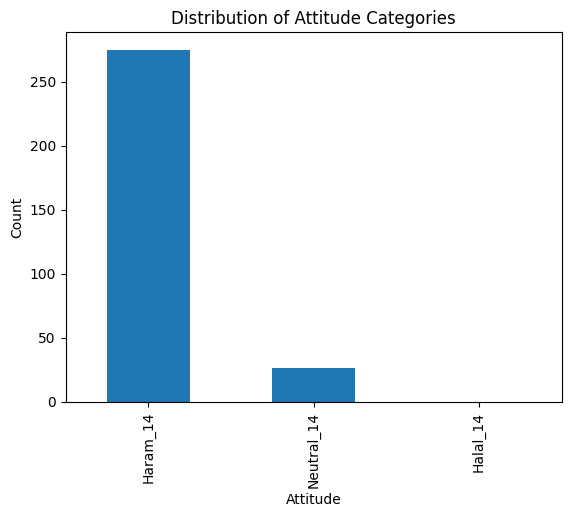


Mean of each sum:
haram_sum      61.378738
neutral_sum    37.292359
halal_sum       1.328904
dtype: float64

Median of each sum:
haram_sum      60.0
neutral_sum    35.0
halal_sum       0.0
dtype: float64
Muslim vs. Non-Muslim Counts:
Muslim            180
Christian          81
Other_Religion     40
dtype: int64

All results have been saved to results.csv


c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [26]:
#Religion Self

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Read CSV
df = pd.read_csv('Final.csv')

# 2. Convert relevant percentage columns to numeric
pct_cols = [
    'seg_amount_q14', 'agt_amount_q14', 'cce_amount_q14',
    'gmb_amount_q14', 'bcd_amount_q14', 'emv_amount_q14',
    'dst_amount_q14', 'cab_amount_q14', 'bbg_amount_q14'
]
for col in pct_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert age to numeric (using raw age)
df['Age'] = pd.to_numeric(df['age'], errors='coerce')

# 3. Process categorical variables
# For religion frequency, we treat it as a categorical variable
df['religion_freq_group'] = df['religion_freq_per_week'].astype(str).str.strip()

# Standardize religion column
df['religion'] = df['religion'].astype(str).str.strip().str.lower()

# Create separate categories: Muslim, Christian, Other
df['Muslim'] = df['religion'].apply(lambda x: 1 if 'muslim' in x or 'islam' in x else 0)
df['Christian'] = df['religion'].apply(lambda x: 1 if 'christian' in x else 0)

# Define 'Other' category for all remaining cases
df['Other_Religion'] = df.apply(lambda row: 1 if (row['Muslim'] == 0 and row['Christian'] == 0) else 0, axis=1)

# Standardize country column (convert to lowercase and strip spaces)
df['country'] = df['country'].astype(str).str.strip().str.lower()

# Categorize countries as US, Qatar, or Other
df['Country_Group'] = df['country'].apply(lambda x: 'US' if x == 'us' 
                                          else 'Qatar' if x == 'qatar' 
                                          else 'Other')


# One-hot encode the categorical variables:
# religion frequency, education_level, education_field, investment_focus, and experience
df = pd.get_dummies(df, 
                    columns=['religion_freq_group', 'education_level', 'education_field', 
                             'investment_focus', 'experience', 'Country_Group'], 
                    drop_first=False)

# 4. Sum up the percentage scores
df['haram_sum']   = df['seg_amount_q14'] + df['agt_amount_q14'] + df['cce_amount_q14']
df['neutral_sum'] = df['gmb_amount_q14'] + df['bcd_amount_q14'] + df['emv_amount_q14']
df['halal_sum']   = df['dst_amount_q14'] + df['cab_amount_q14'] + df['bbg_amount_q14']

def determine_attitude(row):
    sums = {
        'Haram_14': row['haram_sum'],
        'Neutral_14': row['neutral_sum'],
        'Halal_14': row['halal_sum']
    }
    return max(sums, key=sums.get)

df['attitude'] = df.apply(determine_attitude, axis=1)
df['attitude'] = pd.Categorical(df['attitude'], categories=['Haram_14','Neutral_14','Halal_14'])

# 5. Create question group columns (using the original Q columns)
df['risk'] = df[['Q1', 'Q11']].mean(axis=1)
df['islamic_factors'] = df[['Q4', 'Q6', 'Q9', 'Q10', 'Q11']].mean(axis=1)
df['societal'] = df[['Q7', 'Q8']].mean(axis=1)

# 6. Prepare features (X) and outcome (y)
# Define base features: Age, risk, islamic_factors, societal
base_features = ['Age', 'societal', 'Country_Group_Qatar', 'Country_Group_US','Country_Group_Other', 'Muslim', 'Christian', 'Other_Religion']

# Gather all dummy columns from one-hot encoding for the added categorical variables.
# We already have dummies for religion_freq_group, education_level, education_field, investment_focus, and experience.
dummy_features = [col for col in df.columns 
                  if 
                     #col.startswith('religion') or
                     col.startswith('investment_focus_') or
                     col.startswith('experience_')]

# Combine base features and dummy features.
feature_cols = base_features + dummy_features

X = df[feature_cols].copy()

# Map 'Haram_14'->0, 'Neutral_14'->1, 'Halal_14'->2
y = df['attitude'].cat.codes

# Drop NaNs and align X and y
X = X.dropna()
y = y.dropna()
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

print("\nX dtypes after cleaning and encoding:")
print(X.dtypes)

# 7. Check how many classes are actually in y
unique_classes = sorted(y.unique())
print("\nUnique classes in y:", unique_classes)

missing = [c for c in [0, 1, 2] if c not in unique_classes]
if missing:
    print(f"WARNING: Missing classes in y: {missing}")
    print("Model will effectively be binary or single-class.\n")

# 8. Fit multinomial logistic regression
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    penalty='l2',
    C=1.0,
    max_iter=1000
)
model.fit(X, y)
print("Model fitted successfully!")
print("Model classes_:", model.classes_)

# 9. Build a dynamic coefficient table
n_class = len(model.classes_)
coef_shape = model.coef_.shape[0]

if coef_shape == n_class:
    row_labels = [f"Class {c}" for c in model.classes_]
elif n_class == 2 and coef_shape == 1:
    row_labels = [f"Class {model.classes_[1]} vs Class {model.classes_[0]}"]
else:
    row_labels = [f"Row {i}" for i in range(coef_shape)]

coefs_df = pd.DataFrame(model.coef_, columns=X.columns, index=row_labels)
print("\n--- MODEL COEFFICIENTS ---")
print(coefs_df)

# 10. Intercepts
intercepts_df = pd.DataFrame(model.intercept_.reshape(coef_shape, -1),
                             columns=["Intercept"], index=row_labels)
print("\n--- MODEL INTERCEPTS ---")
print(intercepts_df)

# 11. Evaluate with predictions
y_pred = model.predict(X)
label_map = {0: 'Haram_14', 1: 'Neutral_14', 2: 'Halal_14'}

print("\n--- CLASSIFICATION REPORT ---")
target_names = [label_map[c] for c in model.classes_]
print(classification_report(y, y_pred, target_names=target_names))

print("\n--- CONFUSION MATRIX ---")
print(confusion_matrix(y, y_pred))

# 14. Visualize the attitude distribution
print("\nAttitude distribution:")
print(df['attitude'].value_counts(dropna=False))
df['attitude'].value_counts(dropna=False).plot(kind='bar')
plt.title('Distribution of Attitude Categories')
plt.xlabel('Attitude')
plt.ylabel('Count')
plt.show()

print("\nMean of each sum:")
print(df[['haram_sum', 'neutral_sum', 'halal_sum']].mean())

print("\nMedian of each sum:")
print(df[['haram_sum', 'neutral_sum', 'halal_sum']].median())

print("Muslim vs. Non-Muslim Counts:")
print(df[['Muslim', 'Christian','Other_Religion']].sum())


# --- BUILD TABLES FOR COEFFICIENTS AND INTERCEPTS WITH FIXED COLUMNS ---
desired_classes = [0, 1, 2]  # Always want columns for these classes
coef_table = pd.DataFrame(index=X.columns, columns=[f"Class {c}" for c in desired_classes])
intercept_table = pd.DataFrame(index=["Intercept"], columns=[f"Class {c}" for c in desired_classes])

if len(model.classes_) == 2:
    # Binary logistic regression:
    # model.coef_ gives coefficients for Class 1 relative to Class 0.
    # Define Class 0 coefficients as 0 and Class 1 from the model.
    for feature in X.columns:
        coef_table.loc[feature, "Class 0"] = 0.0
    for i, feature in enumerate(X.columns):
        coef_table.loc[feature, "Class 1"] = model.coef_[0][i]
    # Intercepts: reference (Class 0) is 0 and Class 1 from model.intercept_
    intercept_table.loc["Intercept", "Class 0"] = 0.0
    intercept_table.loc["Intercept", "Class 1"] = model.intercept_[0]
    # Class 2 remains NaN (or you can fill with a value if desired)
elif len(model.classes_) == 3:
    # Multinomial logistic regression with three classes.
    for idx, c in enumerate(model.classes_):
        for i, feature in enumerate(X.columns):
            coef_table.loc[feature, f"Class {c}"] = model.coef_[idx, i]
        intercept_table.loc["Intercept", f"Class {c}"] = model.intercept_[idx]
else:
    # Fallback: for any other number of classes, fill what is available.
    for idx, c in enumerate(model.classes_):
        for i, feature in enumerate(X.columns):
            coef_table.loc[feature, f"Class {c}"] = model.coef_[idx, i]
        intercept_table.loc["Intercept", f"Class {c}"] = model.intercept_[idx]

with open("results.csv", "w") as f:
    # Write the coefficients table, transposed so that features are rows and classes are columns
    f.write("=== MODEL COEFFICIENTS ===\n")
    coefs_df.T.to_csv(f)  # Changed from coefs_df.to_csv(f)
    f.write("\n")
    
    # Write the intercepts table, transposed so that 'Intercept' is the row and classes are columns
    f.write("=== MODEL INTERCEPTS ===\n")
    intercepts_df.T.to_csv(f)  # Changed from intercepts_df.to_csv(f)
    f.write("\n")
    
    # Write the classification report (using output_dict=True to convert it to a DataFrame)
    from sklearn.metrics import classification_report
    report = classification_report(y, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    f.write("=== CLASSIFICATION REPORT ===\n")
    report_df.to_csv(f)
    f.write("\n")
    
    # Write the confusion matrix as a DataFrame
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    f.write("=== CONFUSION MATRIX ===\n")
    cm_df.to_csv(f)
    f.write("\n")
    
    # Write the attitude distribution
    f.write("=== ATTITUDE DISTRIBUTION ===\n")
    df['attitude'].value_counts(dropna=False).to_csv(f)
    f.write("\n")
    
    # Write the mean of each sum
    f.write("=== MEAN OF EACH SUM ===\n")
    df[['haram_sum', 'neutral_sum', 'halal_sum']].mean().to_csv(f)
    f.write("\n")
    
    # Write the median of each sum
    f.write("=== MEDIAN OF EACH SUM ===\n")
    df[['haram_sum', 'neutral_sum', 'halal_sum']].median().to_csv(f)
    f.write("\n")

    
print("\nAll results have been saved to results.csv")




X dtypes after cleaning and encoding:
Age                                                int64
islamic_factors                                  float64
societal                                         float64
Country_Group_Qatar                                 bool
Country_Group_US                                    bool
Country_Group_Other                                 bool
religion_freq_group_0                               bool
religion_freq_group_1~2                             bool
religion_freq_group_3~7                             bool
investment_focus_Community Welfare                  bool
investment_focus_Environment Sustainability         bool
investment_focus_Ethical Investment                 bool
investment_focus_Long-Term Security/Stability       bool
investment_focus_Retirement                         bool
investment_focus_Wealth Accumulation                bool
experience_Experienced                              bool
experience_Intermediate                          

c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

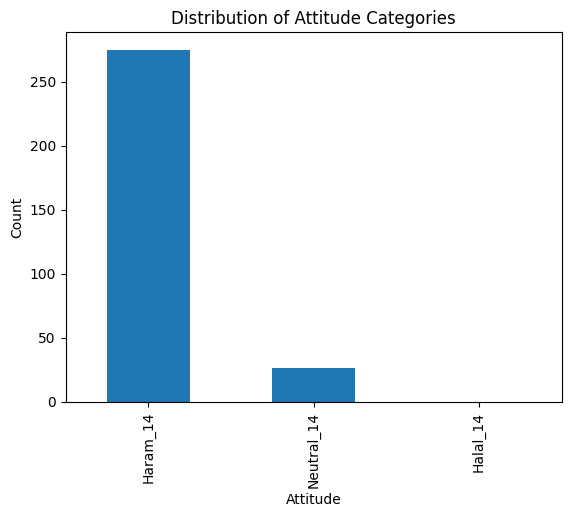


Mean of each sum:
haram_sum      61.378738
neutral_sum    37.292359
halal_sum       1.328904
dtype: float64

Median of each sum:
haram_sum      60.0
neutral_sum    35.0
halal_sum       0.0
dtype: float64

All results have been saved to results.csv


c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [27]:
#Rel Freq Self

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Read CSV
df = pd.read_csv('Final.csv')

# 2. Convert relevant percentage columns to numeric
pct_cols = [
    'seg_amount_q14', 'agt_amount_q14', 'cce_amount_q14',
    'gmb_amount_q14', 'bcd_amount_q14', 'emv_amount_q14',
    'dst_amount_q14', 'cab_amount_q14', 'bbg_amount_q14'
]
for col in pct_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert age to numeric (using raw age)
df['Age'] = pd.to_numeric(df['age'], errors='coerce')

# 3. Process categorical variables
# For religion frequency, we treat it as a categorical variable
df['religion_freq_group'] = df['religion_freq_per_week'].astype(str).str.strip()

# Standardize religion column
df['religion'] = df['religion'].astype(str).str.strip().str.lower()

# Define binary classification: Muslim (1), Non-Muslim (0)
df['Muslim'] = df['religion'].apply(lambda x: 1 if 'muslim' in x or 'islam' in x else 0)

# Create an explicit Non-Muslim column (inverted values)
df['Non_Muslim'] = df['Muslim'].apply(lambda x: 1 if x == 0 else 0)

# Standardize country column (convert to lowercase and strip spaces)
df['country'] = df['country'].astype(str).str.strip().str.lower()

# Categorize countries as US, Qatar, or Other
df['Country_Group'] = df['country'].apply(lambda x: 'US' if x == 'us' 
                                          else 'Qatar' if x == 'qatar' 
                                          else 'Other')


# One-hot encode the categorical variables:
# religion frequency, education_level, education_field, investment_focus, and experience
df = pd.get_dummies(df, 
                    columns=['religion_freq_group', 'education_level', 'education_field', 
                             'investment_focus', 'experience', 'Country_Group'], 
                    drop_first=False)

# 4. Sum up the percentage scores
df['haram_sum']   = df['seg_amount_q14'] + df['agt_amount_q14'] + df['cce_amount_q14']
df['neutral_sum'] = df['gmb_amount_q14'] + df['bcd_amount_q14'] + df['emv_amount_q14']
df['halal_sum']   = df['dst_amount_q14'] + df['cab_amount_q14'] + df['bbg_amount_q14']

def determine_attitude(row):
    sums = {
        'Haram_14': row['haram_sum'],
        'Neutral_14': row['neutral_sum'],
        'Halal_14': row['halal_sum']
    }
    return max(sums, key=sums.get)

df['attitude'] = df.apply(determine_attitude, axis=1)
df['attitude'] = pd.Categorical(df['attitude'], categories=['Haram_14','Neutral_14','Halal_14'])

# 5. Create question group columns (using the original Q columns)
df['risk'] = df[['Q1', 'Q11']].mean(axis=1)
df['islamic_factors'] = df[['Q4', 'Q6', 'Q9', 'Q10', 'Q11']].mean(axis=1)
df['societal'] = df[['Q7', 'Q8']].mean(axis=1)

# 6. Prepare features (X) and outcome (y)
# Define base features: Age, risk, islamic_factors, societal
base_features = ['Age', 'islamic_factors', 'societal', 'Country_Group_Qatar', 'Country_Group_US', 'Country_Group_Other']

# Gather all dummy columns from one-hot encoding for the added categorical variables.
# We already have dummies for religion_freq_group, education_level, education_field, investment_focus, and experience.
dummy_features = [col for col in df.columns 
                  if col.startswith('religion_freq_group_') or 
                     col.startswith('investment_focus_') or
                     col.startswith('experience_')]

# Combine base features and dummy features.
feature_cols = base_features + dummy_features

X = df[feature_cols].copy()

# Map 'Haram_14'->0, 'Neutral_14'->1, 'Halal_14'->2
y = df['attitude'].cat.codes

# Drop NaNs and align X and y
X = X.dropna()
y = y.dropna()
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

print("\nX dtypes after cleaning and encoding:")
print(X.dtypes)

# 7. Check how many classes are actually in y
unique_classes = sorted(y.unique())
print("\nUnique classes in y:", unique_classes)

missing = [c for c in [0, 1, 2] if c not in unique_classes]
if missing:
    print(f"WARNING: Missing classes in y: {missing}")
    print("Model will effectively be binary or single-class.\n")

# 8. Fit multinomial logistic regression
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    penalty='l2',
    C=1.0,
    max_iter=1000
)
model.fit(X, y)
print("Model fitted successfully!")
print("Model classes_:", model.classes_)

# 9. Build a dynamic coefficient table
n_class = len(model.classes_)
coef_shape = model.coef_.shape[0]

if coef_shape == n_class:
    row_labels = [f"Class {c}" for c in model.classes_]
elif n_class == 2 and coef_shape == 1:
    row_labels = [f"Class {model.classes_[1]} vs Class {model.classes_[0]}"]
else:
    row_labels = [f"Row {i}" for i in range(coef_shape)]

coefs_df = pd.DataFrame(model.coef_, columns=X.columns, index=row_labels)
print("\n--- MODEL COEFFICIENTS ---")
print(coefs_df)

# 10. Intercepts
intercepts_df = pd.DataFrame(model.intercept_.reshape(coef_shape, -1),
                             columns=["Intercept"], index=row_labels)
print("\n--- MODEL INTERCEPTS ---")
print(intercepts_df)

# 11. Evaluate with predictions
y_pred = model.predict(X)
label_map = {0: 'Haram_14', 1: 'Neutral_14', 2: 'Halal_14'}

print("\n--- CLASSIFICATION REPORT ---")
target_names = [label_map[c] for c in model.classes_]
print(classification_report(y, y_pred, target_names=target_names))

print("\n--- CONFUSION MATRIX ---")
print(confusion_matrix(y, y_pred))

# 14. Visualize the attitude distribution
print("\nAttitude distribution:")
print(df['attitude'].value_counts(dropna=False))
df['attitude'].value_counts(dropna=False).plot(kind='bar')
plt.title('Distribution of Attitude Categories')
plt.xlabel('Attitude')
plt.ylabel('Count')
plt.show()

print("\nMean of each sum:")
print(df[['haram_sum', 'neutral_sum', 'halal_sum']].mean())

print("\nMedian of each sum:")
print(df[['haram_sum', 'neutral_sum', 'halal_sum']].median())

with open("results.csv", "w") as f:
    # Write the coefficients table, transposed so that features are rows and classes are columns
    f.write("=== MODEL COEFFICIENTS ===\n")
    coefs_df.T.to_csv(f)  # Changed from coefs_df.to_csv(f)
    f.write("\n")
    
    # Write the intercepts table, transposed so that 'Intercept' is the row and classes are columns
    f.write("=== MODEL INTERCEPTS ===\n")
    intercepts_df.T.to_csv(f)  # Changed from intercepts_df.to_csv(f)
    f.write("\n")
    
    # Write the classification report (using output_dict=True to convert it to a DataFrame)
    from sklearn.metrics import classification_report
    report = classification_report(y, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    f.write("=== CLASSIFICATION REPORT ===\n")
    report_df.to_csv(f)
    f.write("\n")
    
    # Write the confusion matrix as a DataFrame
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    f.write("=== CONFUSION MATRIX ===\n")
    cm_df.to_csv(f)
    f.write("\n")
    
    # Write the attitude distribution
    f.write("=== ATTITUDE DISTRIBUTION ===\n")
    df['attitude'].value_counts(dropna=False).to_csv(f)
    f.write("\n")
    
    # Write the mean of each sum
    f.write("=== MEAN OF EACH SUM ===\n")
    df[['haram_sum', 'neutral_sum', 'halal_sum']].mean().to_csv(f)
    f.write("\n")
    
    # Write the median of each sum
    f.write("=== MEDIAN OF EACH SUM ===\n")
    df[['haram_sum', 'neutral_sum', 'halal_sum']].median().to_csv(f)
    f.write("\n")

    
print("\nAll results have been saved to results.csv")


X dtypes after cleaning and encoding:
Age                                                int64
societal                                         float64
Country_Group_Qatar                                 bool
Country_Group_US                                    bool
Country_Group_Other                                 bool
education_level_Bachelor                            bool
education_level_High School Diploma                 bool
education_level_Master                              bool
education_level_Phd                                 bool
education_field_Finance                             bool
education_field_Islamic Finance                     bool
investment_focus_Community Welfare                  bool
investment_focus_Environment Sustainability         bool
investment_focus_Ethical Investment                 bool
investment_focus_Long-Term Security/Stability       bool
investment_focus_Retirement                         bool
investment_focus_Wealth Accumulation             

c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

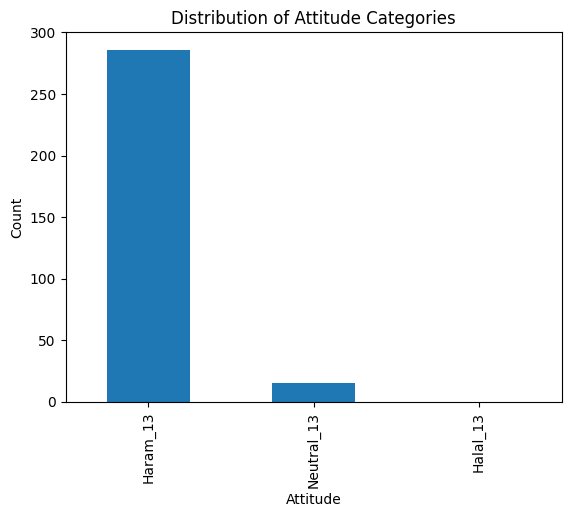


Mean of each sum:
haram_sum      64.651163
neutral_sum    33.754153
halal_sum       1.594684
dtype: float64

Median of each sum:
haram_sum      65.0
neutral_sum    35.0
halal_sum       0.0
dtype: float64

All results have been saved to results.csv


c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
#Education Self

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Read CSV
df = pd.read_csv('Final.csv')

# 2. Convert relevant percentage columns to numeric
pct_cols = [
    'seg_amount_q14', 'agt_amount_q14', 'cce_amount_q14',
    'gmb_amount_q14', 'bcd_amount_q14', 'emv_amount_q14',
    'dst_amount_q14', 'cab_amount_q14', 'bbg_amount_q14'
]
for col in pct_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert age to numeric (using raw age)
df['Age'] = pd.to_numeric(df['age'], errors='coerce')

# 3. Process categorical variables
# For religion frequency, we treat it as a categorical variable
df['religion_freq_group'] = df['religion_freq_per_week'].astype(str).str.strip()

# Standardize religion column
df['religion'] = df['religion'].astype(str).str.strip().str.lower()

# Define binary classification: Muslim (1), Non-Muslim (0)
df['Muslim'] = df['religion'].apply(lambda x: 1 if 'muslim' in x or 'islam' in x else 0)

# Create an explicit Non-Muslim column (inverted values)
df['Non_Muslim'] = df['Muslim'].apply(lambda x: 1 if x == 0 else 0)

# Standardize country column (convert to lowercase and strip spaces)
df['country'] = df['country'].astype(str).str.strip().str.lower()

# Categorize countries as US, Qatar, or Other
df['Country_Group'] = df['country'].apply(lambda x: 'US' if x == 'us' 
                                          else 'Qatar' if x == 'qatar' 
                                          else 'Other')


# One-hot encode the categorical variables:
# religion frequency, education_level, education_field, investment_focus, and experience
df = pd.get_dummies(df, 
                    columns=['religion_freq_group', 'education_level', 'education_field', 
                             'investment_focus', 'experience', 'Country_Group'], 
                    drop_first=False)

# 4. Sum up the percentage scores
df['haram_sum']   = df['seg_amount_q14'] + df['agt_amount_q14'] + df['cce_amount_q14']
df['neutral_sum'] = df['gmb_amount_q14'] + df['bcd_amount_q14'] + df['emv_amount_q14']
df['halal_sum']   = df['dst_amount_q14'] + df['cab_amount_q14'] + df['bbg_amount_q14']

def determine_attitude(row):
    sums = {
        'Haram_14': row['haram_sum'],
        'Neutral_14': row['neutral_sum'],
        'Halal_14': row['halal_sum']
    }
    return max(sums, key=sums.get)

df['attitude'] = df.apply(determine_attitude, axis=1)
df['attitude'] = pd.Categorical(df['attitude'], categories=['Haram_14','Neutral_14','Halal_14'])

# 5. Create question group columns (using the original Q columns)
df['risk'] = df[['Q1', 'Q11']].mean(axis=1)
df['islamic_factors'] = df[['Q4', 'Q6', 'Q9', 'Q10', 'Q11']].mean(axis=1)
df['societal'] = df[['Q7', 'Q8']].mean(axis=1)

# 6. Prepare features (X) and outcome (y)
# Define base features: Age, risk, islamic_factors, societal
base_features = ['Age', 'societal', 'Country_Group_Qatar', 'Country_Group_US', 'Country_Group_Other']

# Gather all dummy columns from one-hot encoding for the added categorical variables.
# We already have dummies for religion_freq_group, education_level, education_field, investment_focus, and experience.
dummy_features = [col for col in df.columns 
                  if  
                     col.startswith('education_level_') or
                     col.startswith('education_field_') or
                     col.startswith('investment_focus_') or
                     col.startswith('experience_')]

# Combine base features and dummy features.
feature_cols = base_features + dummy_features

X = df[feature_cols].copy()

# Map 'Haram_14'->0, 'Neutral_14'->1, 'Halal_14'->2
y = df['attitude'].cat.codes

# Drop NaNs and align X and y
X = X.dropna()
y = y.dropna()
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

print("\nX dtypes after cleaning and encoding:")
print(X.dtypes)

# 7. Check how many classes are actually in y
unique_classes = sorted(y.unique())
print("\nUnique classes in y:", unique_classes)

missing = [c for c in [0, 1, 2] if c not in unique_classes]
if missing:
    print(f"WARNING: Missing classes in y: {missing}")
    print("Model will effectively be binary or single-class.\n")

# 8. Fit multinomial logistic regression
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    penalty='l2',
    C=1.0,
    max_iter=1000
)
model.fit(X, y)
print("Model fitted successfully!")
print("Model classes_:", model.classes_)

# 9. Build a dynamic coefficient table
n_class = len(model.classes_)
coef_shape = model.coef_.shape[0]

if coef_shape == n_class:
    row_labels = [f"Class {c}" for c in model.classes_]
elif n_class == 2 and coef_shape == 1:
    row_labels = [f"Class {model.classes_[1]} vs Class {model.classes_[0]}"]
else:
    row_labels = [f"Row {i}" for i in range(coef_shape)]

coefs_df = pd.DataFrame(model.coef_, columns=X.columns, index=row_labels)
print("\n--- MODEL COEFFICIENTS ---")
print(coefs_df)

# 10. Intercepts
intercepts_df = pd.DataFrame(model.intercept_.reshape(coef_shape, -1),
                             columns=["Intercept"], index=row_labels)
print("\n--- MODEL INTERCEPTS ---")
print(intercepts_df)

# 11. Evaluate with predictions
y_pred = model.predict(X)
label_map = {0: 'Haram_14', 1: 'Neutral_14', 2: 'Halal_14'}

print("\n--- CLASSIFICATION REPORT ---")
target_names = [label_map[c] for c in model.classes_]
print(classification_report(y, y_pred, target_names=target_names))

print("\n--- CONFUSION MATRIX ---")
print(confusion_matrix(y, y_pred))

# 14. Visualize the attitude distribution
print("\nAttitude distribution:")
print(df['attitude'].value_counts(dropna=False))
df['attitude'].value_counts(dropna=False).plot(kind='bar')
plt.title('Distribution of Attitude Categories')
plt.xlabel('Attitude')
plt.ylabel('Count')
plt.show()

print("\nMean of each sum:")
print(df[['haram_sum', 'neutral_sum', 'halal_sum']].mean())

print("\nMedian of each sum:")
print(df[['haram_sum', 'neutral_sum', 'halal_sum']].median())

with open("results.csv", "w") as f:
    # Write the coefficients table, transposed so that features are rows and classes are columns
    f.write("=== MODEL COEFFICIENTS ===\n")
    coefs_df.T.to_csv(f)  # Changed from coefs_df.to_csv(f)
    f.write("\n")
    
    # Write the intercepts table, transposed so that 'Intercept' is the row and classes are columns
    f.write("=== MODEL INTERCEPTS ===\n")
    intercepts_df.T.to_csv(f)  # Changed from intercepts_df.to_csv(f)
    f.write("\n")
    
    # Write the classification report (using output_dict=True to convert it to a DataFrame)
    from sklearn.metrics import classification_report
    report = classification_report(y, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    f.write("=== CLASSIFICATION REPORT ===\n")
    report_df.to_csv(f)
    f.write("\n")
    
    # Write the confusion matrix as a DataFrame
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    f.write("=== CONFUSION MATRIX ===\n")
    cm_df.to_csv(f)
    f.write("\n")
    
    # Write the attitude distribution
    f.write("=== ATTITUDE DISTRIBUTION ===\n")
    df['attitude'].value_counts(dropna=False).to_csv(f)
    f.write("\n")
    
    # Write the mean of each sum
    f.write("=== MEAN OF EACH SUM ===\n")
    df[['haram_sum', 'neutral_sum', 'halal_sum']].mean().to_csv(f)
    f.write("\n")
    
    # Write the median of each sum
    f.write("=== MEDIAN OF EACH SUM ===\n")
    df[['haram_sum', 'neutral_sum', 'halal_sum']].median().to_csv(f)
    f.write("\n")

    
print("\nAll results have been saved to results.csv")


X dtypes after cleaning and encoding:
Age                                                int64
risk                                             float64
societal                                         float64
Country_Group_Qatar                                 bool
Country_Group_US                                    bool
investment_focus_Community Welfare                  bool
investment_focus_Environment Sustainability         bool
investment_focus_Ethical Investment                 bool
investment_focus_Long-Term Security/Stability       bool
investment_focus_Retirement                         bool
investment_focus_Wealth Accumulation                bool
experience_Experienced                              bool
experience_Intermediate                             bool
experience_Novice                                   bool
dtype: object

Unique classes in y: [0, 1]
Model will effectively be binary or single-class.

Model fitted successfully!
Model classes_: [0 1]

--- MODEL COEFFICIE

c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

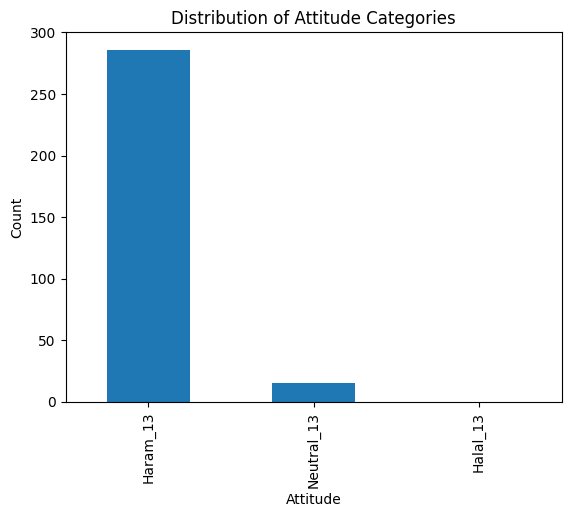


Mean of each sum:
haram_sum      64.651163
neutral_sum    33.754153
halal_sum       1.594684
dtype: float64

Median of each sum:
haram_sum      65.0
neutral_sum    35.0
halal_sum       0.0
dtype: float64

All results have been saved to results.csv


c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
#Risk Self

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Read CSV
df = pd.read_csv('Final.csv')

# 2. Convert relevant percentage columns to numeric
pct_cols = [
    'seg_amount_q14', 'agt_amount_q14', 'cce_amount_q14',
    'gmb_amount_q14', 'bcd_amount_q14', 'emv_amount_q14',
    'dst_amount_q14', 'cab_amount_q14', 'bbg_amount_q14'
]
for col in pct_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert age to numeric (using raw age)
df['Age'] = pd.to_numeric(df['age'], errors='coerce')

# 3. Process categorical variables
# For religion frequency, we treat it as a categorical variable
df['religion_freq_group'] = df['religion_freq_per_week'].astype(str).str.strip()

# Standardize religion column
df['religion'] = df['religion'].astype(str).str.strip().str.lower()

# Define binary classification: Muslim (1), Non-Muslim (0)
df['Muslim'] = df['religion'].apply(lambda x: 1 if 'muslim' in x or 'islam' in x else 0)

# Create an explicit Non-Muslim column (inverted values)
df['Non_Muslim'] = df['Muslim'].apply(lambda x: 1 if x == 0 else 0)

# Standardize country column (convert to lowercase and strip spaces)
df['country'] = df['country'].astype(str).str.strip().str.lower()

# Categorize countries as US, Qatar, or Other
df['Country_Group'] = df['country'].apply(lambda x: 'US' if x == 'us' 
                                          else 'Qatar' if x == 'qatar' 
                                          else 'Other')


# One-hot encode the categorical variables:
# religion frequency, education_level, education_field, investment_focus, and experience
df = pd.get_dummies(df, 
                    columns=['religion_freq_group', 'education_level', 'education_field', 
                             'investment_focus', 'experience', 'Country_Group'], 
                    drop_first=False)

# 4. Sum up the percentage scores
df['haram_sum']   = df['seg_amount_q14'] + df['agt_amount_q14'] + df['cce_amount_q14']
df['neutral_sum'] = df['gmb_amount_q14'] + df['bcd_amount_q14'] + df['emv_amount_q14']
df['halal_sum']   = df['dst_amount_q14'] + df['cab_amount_q14'] + df['bbg_amount_q14']

def determine_attitude(row):
    sums = {
        'Haram_14': row['haram_sum'],
        'Neutral_14': row['neutral_sum'],
        'Halal_14': row['halal_sum']
    }
    return max(sums, key=sums.get)

df['attitude'] = df.apply(determine_attitude, axis=1)
df['attitude'] = pd.Categorical(df['attitude'], categories=['Haram_14','Neutral_14','Halal_14'])

# 5. Create question group columns (using the original Q columns)
df['risk'] = df[['Q1', 'Q11']].mean(axis=1)
df['islamic_factors'] = df[['Q4', 'Q6', 'Q9', 'Q10', 'Q11']].mean(axis=1)
df['societal'] = df[['Q7', 'Q8']].mean(axis=1)

# 6. Prepare features (X) and outcome (y)
# Define base features: Age, risk, islamic_factors, societal
base_features = ['Age', 'risk', 'societal', 'Country_Group_Qatar', 'Country_Group_US']

# Gather all dummy columns from one-hot encoding for the added categorical variables.
# We already have dummies for religion_freq_group, education_level, education_field, investment_focus, and experience.
dummy_features = [col for col in df.columns 
                  if
                     col.startswith('investment_focus_') or
                     col.startswith('experience_')]

# Combine base features and dummy features.
feature_cols = base_features + dummy_features

X = df[feature_cols].copy()

# Map 'Haram_14'->0, 'Neutral_14'->1, 'Halal_14'->2
y = df['attitude'].cat.codes

# Drop NaNs and align X and y
X = X.dropna()
y = y.dropna()
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

print("\nX dtypes after cleaning and encoding:")
print(X.dtypes)

# 7. Check how many classes are actually in y
unique_classes = sorted(y.unique())
print("\nUnique classes in y:", unique_classes)

missing = [c for c in [0, 1, 2] if c not in unique_classes]
if missing:
    print(f"WARNING: Missing classes in y: {missing}")
    print("Model will effectively be binary or single-class.\n")

# 8. Fit multinomial logistic regression
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    penalty='l2',
    C=1.0,
    max_iter=1000
)
model.fit(X, y)
print("Model fitted successfully!")
print("Model classes_:", model.classes_)

# 9. Build a dynamic coefficient table
n_class = len(model.classes_)
coef_shape = model.coef_.shape[0]

if coef_shape == n_class:
    row_labels = [f"Class {c}" for c in model.classes_]
elif n_class == 2 and coef_shape == 1:
    row_labels = [f"Class {model.classes_[1]} vs Class {model.classes_[0]}"]
else:
    row_labels = [f"Row {i}" for i in range(coef_shape)]

coefs_df = pd.DataFrame(model.coef_, columns=X.columns, index=row_labels)
print("\n--- MODEL COEFFICIENTS ---")
print(coefs_df)

# 10. Intercepts
intercepts_df = pd.DataFrame(model.intercept_.reshape(coef_shape, -1),
                             columns=["Intercept"], index=row_labels)
print("\n--- MODEL INTERCEPTS ---")
print(intercepts_df)

# 11. Evaluate with predictions
y_pred = model.predict(X)
label_map = {0: 'Haram_14', 1: 'Neutral_14', 2: 'Halal_14'}

print("\n--- CLASSIFICATION REPORT ---")
target_names = [label_map[c] for c in model.classes_]
print(classification_report(y, y_pred, target_names=target_names))

print("\n--- CONFUSION MATRIX ---")
print(confusion_matrix(y, y_pred))

# 14. Visualize the attitude distribution
print("\nAttitude distribution:")
print(df['attitude'].value_counts(dropna=False))
df['attitude'].value_counts(dropna=False).plot(kind='bar')
plt.title('Distribution of Attitude Categories')
plt.xlabel('Attitude')
plt.ylabel('Count')
plt.show()

print("\nMean of each sum:")
print(df[['haram_sum', 'neutral_sum', 'halal_sum']].mean())

print("\nMedian of each sum:")
print(df[['haram_sum', 'neutral_sum', 'halal_sum']].median())


with open("results.csv", "w") as f:
    # Write the coefficients table, transposed so that features are rows and classes are columns
    f.write("=== MODEL COEFFICIENTS ===\n")
    coefs_df.T.to_csv(f)  # Changed from coefs_df.to_csv(f)
    f.write("\n")
    
    # Write the intercepts table, transposed so that 'Intercept' is the row and classes are columns
    f.write("=== MODEL INTERCEPTS ===\n")
    intercepts_df.T.to_csv(f)  # Changed from intercepts_df.to_csv(f)
    f.write("\n")
    
    # Write the classification report (using output_dict=True to convert it to a DataFrame)
    from sklearn.metrics import classification_report
    report = classification_report(y, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    f.write("=== CLASSIFICATION REPORT ===\n")
    report_df.to_csv(f)
    f.write("\n")
    
    # Write the confusion matrix as a DataFrame
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    f.write("=== CONFUSION MATRIX ===\n")
    cm_df.to_csv(f)
    f.write("\n")
    
    # Write the attitude distribution
    f.write("=== ATTITUDE DISTRIBUTION ===\n")
    df['attitude'].value_counts(dropna=False).to_csv(f)
    f.write("\n")
    
    # Write the mean of each sum
    f.write("=== MEAN OF EACH SUM ===\n")
    df[['haram_sum', 'neutral_sum', 'halal_sum']].mean().to_csv(f)
    f.write("\n")
    
    # Write the median of each sum
    f.write("=== MEDIAN OF EACH SUM ===\n")
    df[['haram_sum', 'neutral_sum', 'halal_sum']].median().to_csv(f)
    f.write("\n")

    
print("\nAll results have been saved to results.csv")

